# D11 Bending Stiffness Comparison Across Calculation Pathways

This notebook compares D11 (bending stiffness) values calculated via all possible parameterization pathways for ECTP slabs in the snow pilot dataset.

## Objectives

1. Execute all calculation pathways for each ECTP slab
2. Analyze data availability and pathway success rates
3. Compare D11 distributions across pathways
4. Quantify inter-pathway variability (per slab)
5. Identify sources of uncertainty

## Dataset

- **Source**: SnowPilot CAAML files
- **Slabs**: ECTP (Extended Column Test with Propagation) failure layers
- **Expected**: ~14,776 slabs from ~12,347 snow pits

## D11 Calculation Pathways

D11 (bending stiffness) requires calculating:
- **Density** (ρ) - 4 methods (3 calculated + 1 measured)
- **Elastic modulus** (E) - 4 methods
- **Poisson's ratio** (ν) - 2 methods
- **Layer geometry** (depth, thickness) - measured

**Total pathways**: 4 × 4 × 2 = **32 unique pathways**

Note: The `data_flow` density pathway uses measured density directly when available.

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from snowpyt_mechparams import ExecutionEngine
from snowpyt_mechparams.graph import graph
from snowpyt_mechparams.algorithm import find_parameterizations
from snowpyt_mechparams.snowpilot_utils import parse_caaml_file
from snowpyt_mechparams.data_structures import Pit

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports successful")

✓ Imports successful


## 2. Verify Pathway Discovery

Confirm the algorithm finds all 32 D11 pathways:

In [2]:
# Get D11 node from graph
D11_node = graph.get_node("D11")

# Find all calculation pathways
all_D11_pathways = find_parameterizations(graph, D11_node)

print(f"Total D11 calculation pathways discovered: {len(all_D11_pathways)}")
print(f"Expected: 4 density × 4 elastic_modulus × 2 poissons_ratio = 32")
print(f"\n✓ Pathway discovery verified")

# Show first 3 pathways as examples
print("\nExample pathways:")
for i, pathway in enumerate(all_D11_pathways[:3], 1):
    print(f"\n{i}. {pathway}")

Total D11 calculation pathways discovered: 32
Expected: 4 density × 4 elastic_modulus × 2 poissons_ratio = 32

✓ Pathway discovery verified

Example pathways:

1. branch 1: snow_pit -- data_flow --> layer_thickness -- data_flow --> zi
branch 2: snow_pit -- data_flow --> measured_density -- data_flow --> density -- data_flow --> merge_density_grain_form
branch 3: snow_pit -- data_flow --> measured_grain_form -- data_flow --> merge_density_grain_form
branch 4: snow_pit -- data_flow --> measured_grain_form -- kochle --> poissons_ratio -- data_flow --> merge_E_nu
merge branch 1: zi
merge branch 2, branch 3: merge_density_grain_form -- bergfeld --> elastic_modulus
merge branch 2, branch 3, branch 4: merge_E_nu
merge branch 1, branch 2, branch 3, branch 4: merge_zi_E_nu -- weissgraeber_rosendahl --> D11

2. branch 1: snow_pit -- data_flow --> layer_thickness -- data_flow --> zi
branch 2: snow_pit -- data_flow --> measured_density -- data_flow --> density -- data_flow --> merge_density_grain_

## 3. Load ECTP Slabs from Dataset

In [3]:
# Locate CAAML files
data_dir = Path.cwd() / 'data'
caaml_files = list(data_dir.glob('snowpits-*-caaml.xml'))

print(f"Data directory: {data_dir}")
print(f"Found {len(caaml_files):,} CAAML files")

Data directory: /Users/marykate/Desktop/Snow/SnowPyt-MechParams/examples/data
Found 50,278 CAAML files


In [4]:
# Parse CAAML files
print("Parsing CAAML files...")

pits = []
failed_files = []

for filepath in tqdm(caaml_files, desc="Processing files"):
    try:
        snow_pit = parse_caaml_file(str(filepath))
        pit = Pit.from_snow_pit(snow_pit)
        pits.append(pit)
    except Exception as e:
        failed_files.append((filepath.name, str(e)))

print(f"\nSuccessfully parsed: {len(pits):,} pits")
print(f"Failed: {len(failed_files)} files")

Parsing CAAML files...


Processing files: 100%|██████████| 50278/50278 [00:14<00:00, 3458.18it/s]


Successfully parsed: 50,278 pits
Failed: 0 files


In [5]:
# Create slabs from ECTP failure layers
print("Creating slabs from ECTP failures...")

all_slabs = []
pits_with_ectp = 0

for pit in tqdm(pits, desc="Creating slabs"):
    slabs = pit.create_slabs(weak_layer_def="ECTP_failure_layer")
    if slabs:
        pits_with_ectp += 1
        all_slabs.extend(slabs)

print(f"\nPits processed: {len(pits):,}")
print(f"Pits with ECTP failures: {pits_with_ectp:,} ({100*pits_with_ectp/len(pits):.1f}%)")
print(f"Total ECTP slabs: {len(all_slabs):,}")

Creating slabs from ECTP failures...


Creating slabs: 100%|██████████| 50278/50278 [00:00<00:00, 854981.62it/s]


Pits processed: 50,278
Pits with ECTP failures: 12,347 (24.6%)
Total ECTP slabs: 14,776


## 4. Execute All Pathways for D11

Execute all 32 pathways for each slab. The execution engine uses dynamic programming to cache intermediate results, avoiding redundant calculations when pathways share common sub-computations.

**Expected executions**: ~14,776 slabs × 32 pathways = ~473,000 pathway executions

In [6]:
# Initialize execution engine
engine = ExecutionEngine(graph)

print(f"Executing all pathways for {len(all_slabs):,} slabs...")
print(f"Total pathway executions: {len(all_slabs) * 32:,}")
print("\nNote: Dynamic programming caches layer-level results within each slab.")

Executing all pathways for 14,776 slabs...
Total pathway executions: 472,832

Note: Dynamic programming caches layer-level results within each slab.


In [7]:
# Execute pathways and collect results
results_data = []

for slab_idx, slab in enumerate(tqdm(all_slabs, desc="Executing pathways")):
    try:
        # Execute all pathways for this slab
        results = engine.execute_all(
            slab=slab,
            target_parameter='D11'
        )
        
        # Record results for each pathway
        for pathway_desc, pathway_result in results.pathways.items():
            record = {
                'pit_id': slab.pit_id,
                'slab_id': slab.slab_id,
                'slab_index': slab_idx,
                'pathway_description': pathway_desc,
                'success': pathway_result.success,
                'num_layers': len(slab.layers),
                'slab_thickness_cm': slab.total_thickness,
                'slope_angle_deg': slab.angle,
            }
            
            # Extract D11 value if available
            if pathway_result.success and pathway_result.slab and pathway_result.slab.D11:
                D11_value = pathway_result.slab.D11
                record['D11'] = D11_value.nominal_value
                record['D11_uncertainty'] = D11_value.std_dev
            else:
                record['D11'] = None
                record['D11_uncertainty'] = None
            
            # Extract method names
            record['density_method'] = pathway_result.methods_used.get('density', None)
            record['elastic_modulus_method'] = pathway_result.methods_used.get('elastic_modulus', None)
            record['poissons_ratio_method'] = pathway_result.methods_used.get('poissons_ratio', None)
            
            results_data.append(record)
    
    except Exception as e:
        # Record execution error
        results_data.append({
            'pit_id': slab.pit_id,
            'slab_id': slab.slab_id,
            'slab_index': slab_idx,
            'pathway_description': 'EXECUTION_ERROR',
            'success': False,
            'error_message': str(e),
        })

# Create DataFrame
df_results = pd.DataFrame(results_data)

print(f"\nTotal pathway executions: {len(df_results):,}")
print(f"Successful calculations: {df_results['success'].sum():,}")
print(f"Failed calculations: {(~df_results['success']).sum():,}")
print(f"Success rate: {100 * df_results['success'].mean():.1f}%")

Executing pathways: 100%|██████████| 14776/14776 [00:28<00:00, 523.93it/s]



Total pathway executions: 472,832
Successful calculations: 12,370
Failed calculations: 460,462
Success rate: 2.6%


In [8]:
# Save raw results
output_file = 'D11_pathway_comparison_raw.csv'
df_results.to_csv(output_file, index=False)
print(f"Raw results saved: {output_file}")
print(f"File size: {Path(output_file).stat().st_size / 1024 / 1024:.1f} MB")

Raw results saved: D11_pathway_comparison_raw.csv
File size: 68.2 MB


## 5. Pathway Success Rate Analysis

Analyze which pathways have higher success rates and identify factors affecting failure.

In [9]:
print("="*80)
print("PATHWAY SUCCESS RATE ANALYSIS")
print("="*80)

# Calculate success rates by pathway
pathway_stats = df_results.groupby('pathway_description').agg({
    'success': ['sum', 'count', 'mean']
}).reset_index()

pathway_stats.columns = ['pathway', 'successful', 'total', 'success_rate']
pathway_stats['success_rate_%'] = 100 * pathway_stats['success_rate']
pathway_stats = pathway_stats.sort_values('success_rate_%', ascending=False)

print(f"\nTop 10 pathways by success rate:")
print(pathway_stats[['pathway', 'successful', 'total', 'success_rate_%']].head(10).to_string(index=False))

print(f"\n\nBottom 10 pathways by success rate:")
print(pathway_stats[['pathway', 'successful', 'total', 'success_rate_%']].tail(10).to_string(index=False))

PATHWAY SUCCESS RATE ANALYSIS

Top 10 pathways by success rate:
                                                                        pathway  successful  total  success_rate_%
  density=kim_jamieson_table5 | elastic_modulus=wautier | poissons_ratio=kochle         737  14776        4.987818
density=kim_jamieson_table5 | elastic_modulus=schottner | poissons_ratio=kochle         737  14776        4.987818
  density=kim_jamieson_table2 | elastic_modulus=wautier | poissons_ratio=kochle         737  14776        4.987818
         density=geldsetzer | elastic_modulus=schottner | poissons_ratio=kochle         737  14776        4.987818
density=kim_jamieson_table2 | elastic_modulus=schottner | poissons_ratio=kochle         737  14776        4.987818
           density=geldsetzer | elastic_modulus=wautier | poissons_ratio=kochle         737  14776        4.987818
   density=kim_jamieson_table2 | elastic_modulus=kochle | poissons_ratio=kochle         499  14776        3.377098
   density=kim_j

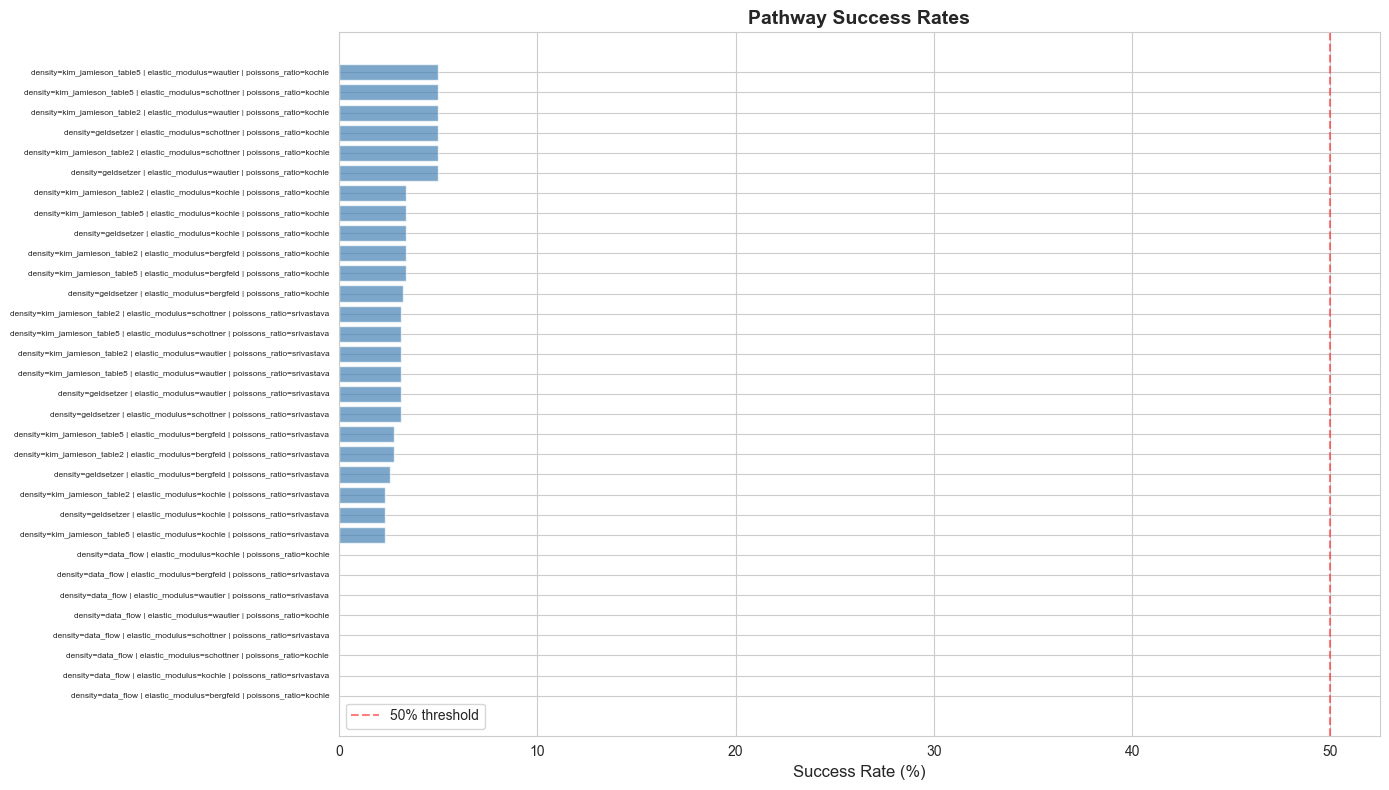

✓ Figure saved: pathway_success_rates.png


In [10]:
# Visualize success rates
fig, ax = plt.subplots(figsize=(14, 8))

pathway_stats_sorted = pathway_stats.sort_values('success_rate_%', ascending=True)
y_pos = np.arange(len(pathway_stats_sorted))

ax.barh(y_pos, pathway_stats_sorted['success_rate_%'], color='steelblue', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(pathway_stats_sorted['pathway'], fontsize=6)
ax.set_xlabel('Success Rate (%)', fontsize=12)
ax.set_title('Pathway Success Rates', fontsize=14, fontweight='bold')
ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()

plt.tight_layout()
plt.savefig('pathway_success_rates.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: pathway_success_rates.png")

In [11]:
# Analyze success rates by method type
print("\n" + "="*80)
print("SUCCESS RATES BY METHOD TYPE")
print("="*80)

# Success by density method
density_success = df_results.groupby('density_method')['success'].agg(['sum', 'count', 'mean'])
density_success.columns = ['successful', 'total', 'success_rate']
density_success['success_rate_%'] = 100 * density_success['success_rate']
density_success = density_success.sort_values('success_rate_%', ascending=False)

print("\nDensity methods:")
print(density_success[['successful', 'total', 'success_rate_%']].to_string())

# Success by elastic modulus method
E_success = df_results.groupby('elastic_modulus_method')['success'].agg(['sum', 'count', 'mean'])
E_success.columns = ['successful', 'total', 'success_rate']
E_success['success_rate_%'] = 100 * E_success['success_rate']
E_success = E_success.sort_values('success_rate_%', ascending=False)

print("\nElastic modulus methods:")
print(E_success[['successful', 'total', 'success_rate_%']].to_string())

# Success by Poisson's ratio method
nu_success = df_results.groupby('poissons_ratio_method')['success'].agg(['sum', 'count', 'mean'])
nu_success.columns = ['successful', 'total', 'success_rate']
nu_success['success_rate_%'] = 100 * nu_success['success_rate']
nu_success = nu_success.sort_values('success_rate_%', ascending=False)

print("\nPoisson's ratio methods:")
print(nu_success[['successful', 'total', 'success_rate_%']].to_string())


SUCCESS RATES BY METHOD TYPE

Density methods:
                     successful   total  success_rate_%
density_method                                         
kim_jamieson_table5        4141  118208        3.503147
kim_jamieson_table2        4140  118208        3.502301
geldsetzer                 4089  118208        3.459157
data_flow                     0  118208        0.000000

Elastic modulus methods:
                        successful   total  success_rate_%
elastic_modulus_method                                    
schottner                     3594  118208        3.040403
wautier                       3594  118208        3.040403
bergfeld                      2665  118208        2.254501
kochle                        2517  118208        2.129298

Poisson's ratio methods:
                       successful   total  success_rate_%
poissons_ratio_method                                    
kochle                       7388  236416        3.125000
srivastava                   4982  2

## 6. D11 Statistics by Pathway

Compare D11 distributions across successful pathways.

In [12]:
print("="*80)
print("D11 STATISTICS BY PATHWAY")
print("="*80)

# Filter to successful calculations with D11 values
df_success = df_results[(df_results['success'] == True) & (df_results['D11'].notna())].copy()

print(f"\nSuccessful D11 calculations: {len(df_success):,}")
print(f"Unique slabs: {df_success['slab_id'].nunique():,}")
print(f"Unique pathways: {df_success['pathway_description'].nunique()}")

# Calculate D11 statistics for each pathway
pathway_D11_stats = df_success.groupby('pathway_description')['D11'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).reset_index()

pathway_D11_stats.columns = ['pathway', 'n', 'mean_D11', 'median_D11', 'std_D11', 'min_D11', 'max_D11']
pathway_D11_stats = pathway_D11_stats.sort_values('mean_D11', ascending=False)

print("\nTop 15 pathways by mean D11:")
print(pathway_D11_stats.head(15).to_string(index=False, float_format='%.2f'))

D11 STATISTICS BY PATHWAY

Successful D11 calculations: 12,370
Unique slabs: 815
Unique pathways: 24

Top 15 pathways by mean D11:
                                                                            pathway   n     mean_D11  median_D11      std_D11  min_D11       max_D11
    density=kim_jamieson_table2 | elastic_modulus=schottner | poissons_ratio=kochle 737 201757320.58 32835175.20 546828892.94  2698.71 7014146614.44
      density=kim_jamieson_table5 | elastic_modulus=wautier | poissons_ratio=kochle 737 201757320.58 32835175.20 546828892.94  2698.71 7014146614.44
             density=geldsetzer | elastic_modulus=schottner | poissons_ratio=kochle 737 201757320.58 32835175.20 546828892.94  2698.71 7014146614.44
    density=kim_jamieson_table5 | elastic_modulus=schottner | poissons_ratio=kochle 737 201757320.58 32835175.20 546828892.94  2698.71 7014146614.44
               density=geldsetzer | elastic_modulus=wautier | poissons_ratio=kochle 737 201757320.58 32835175.20 546828892.9

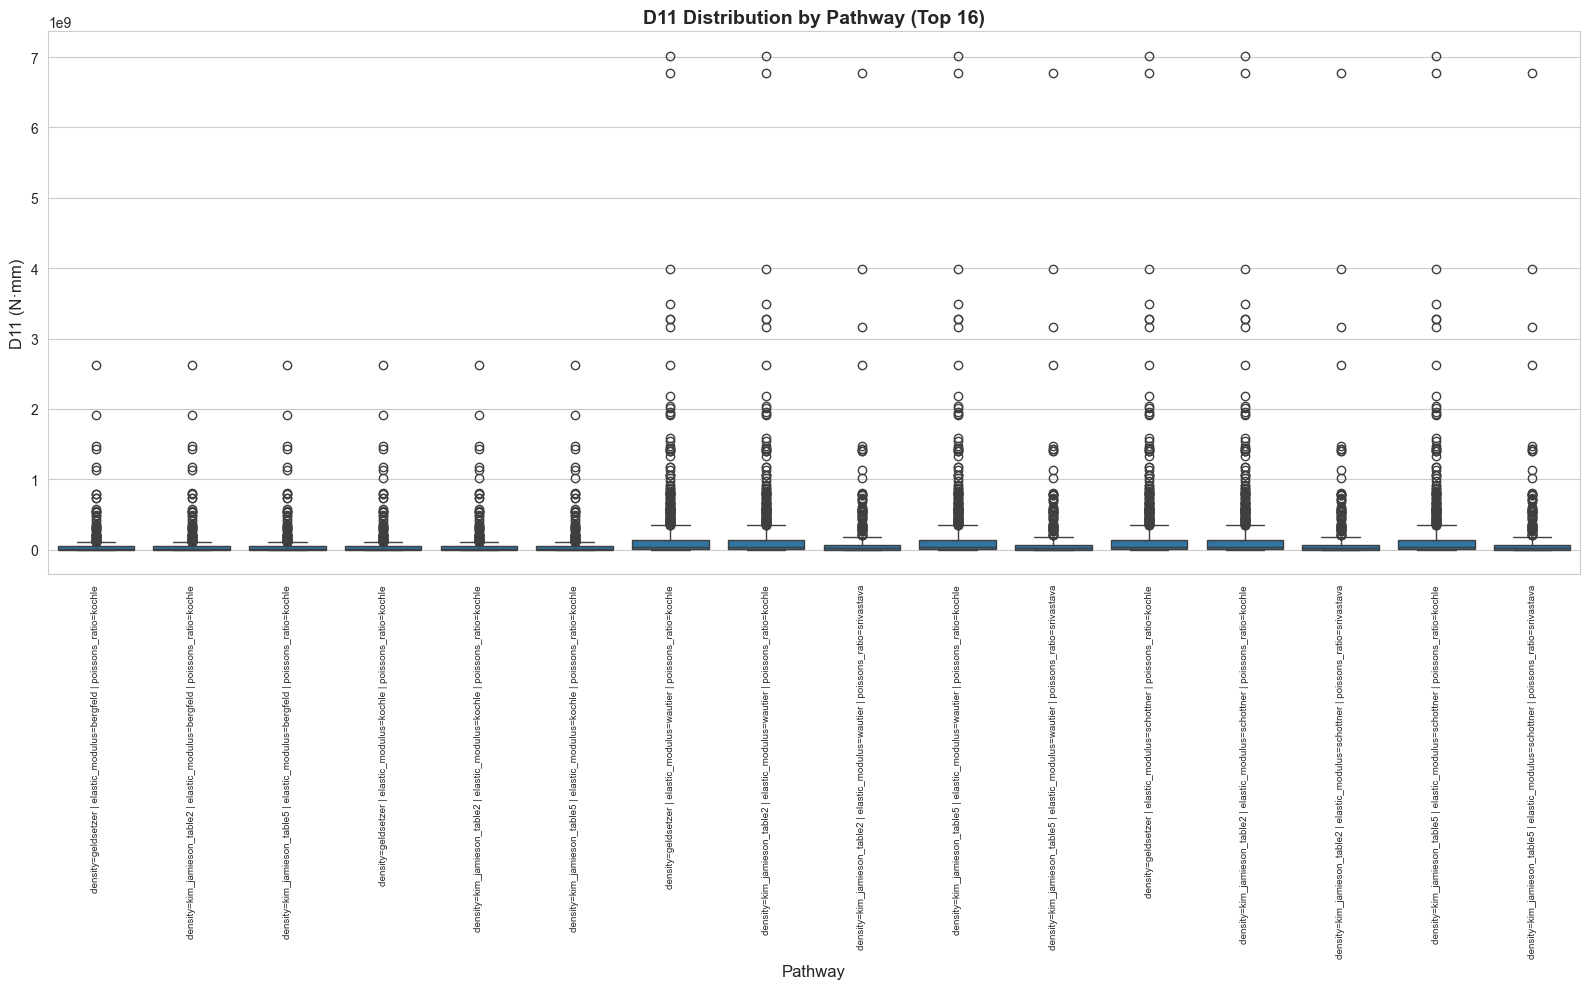

✓ Figure saved: D11_boxplot_by_pathway.png


In [13]:
# Boxplot of D11 by pathway (top pathways only)
fig, ax = plt.subplots(figsize=(16, 10))

# Select top 16 pathways by count
top_pathways = pathway_D11_stats.nlargest(16, 'n')['pathway'].tolist()
df_top = df_success[df_success['pathway_description'].isin(top_pathways)]

sns.boxplot(data=df_top, x='pathway_description', y='D11', ax=ax)
ax.set_xlabel('Pathway', fontsize=12)
ax.set_ylabel('D11 (N·mm)', fontsize=12)
ax.set_title('D11 Distribution by Pathway (Top 16)', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig('D11_boxplot_by_pathway.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: D11_boxplot_by_pathway.png")

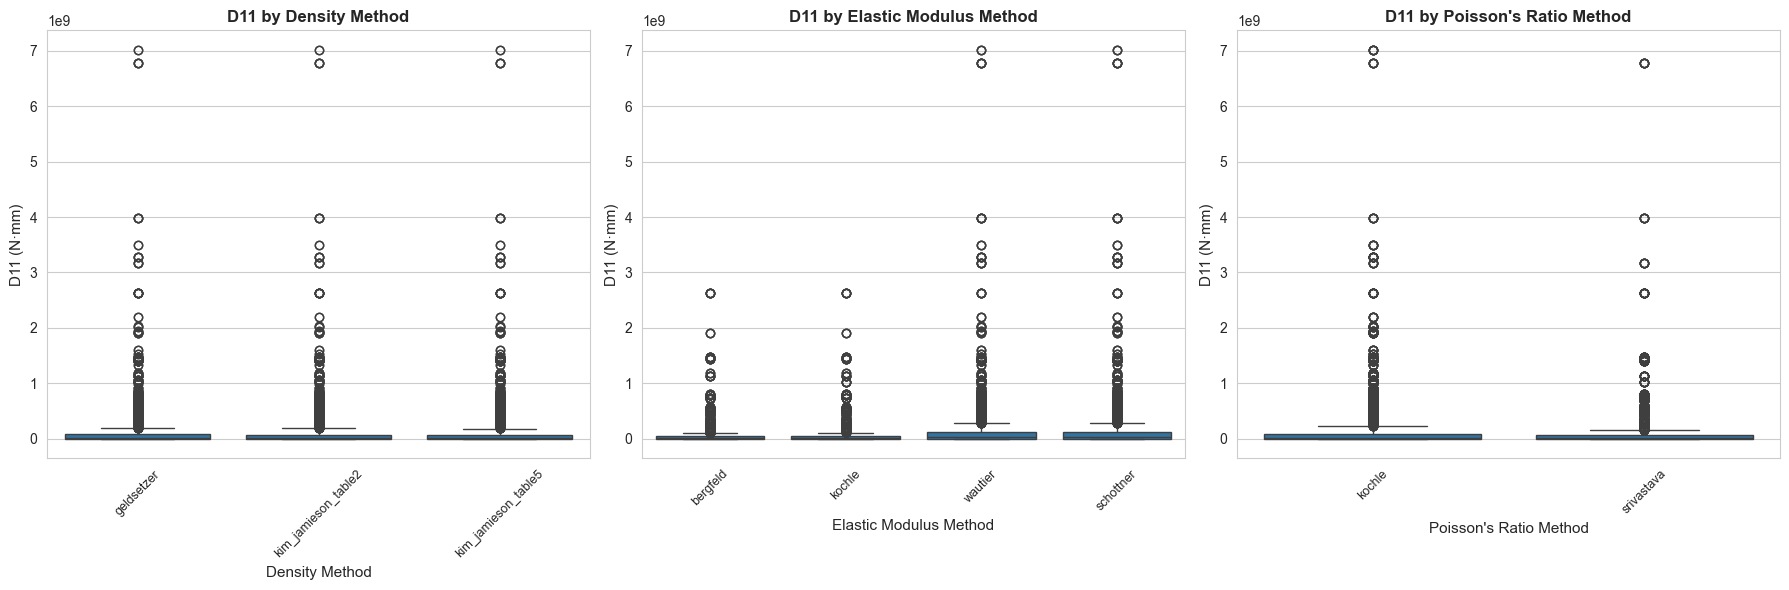

✓ Figure saved: D11_by_method_type.png


In [14]:
# Compare D11 distributions by method type
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# By density method
sns.boxplot(data=df_success, x='density_method', y='D11', ax=axes[0])
axes[0].set_xlabel('Density Method', fontsize=11)
axes[0].set_ylabel('D11 (N·mm)', fontsize=11)
axes[0].set_title('D11 by Density Method', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

# By elastic modulus method
sns.boxplot(data=df_success, x='elastic_modulus_method', y='D11', ax=axes[1])
axes[1].set_xlabel('Elastic Modulus Method', fontsize=11)
axes[1].set_ylabel('D11 (N·mm)', fontsize=11)
axes[1].set_title('D11 by Elastic Modulus Method', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# By Poisson's ratio method
sns.boxplot(data=df_success, x='poissons_ratio_method', y='D11', ax=axes[2])
axes[2].set_xlabel("Poisson's Ratio Method", fontsize=11)
axes[2].set_ylabel('D11 (N·mm)', fontsize=11)
axes[2].set_title("D11 by Poisson's Ratio Method", fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.savefig('D11_by_method_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: D11_by_method_type.png")

## 7. Inter-Pathway Variability Analysis

For each slab, quantify how much D11 varies across different calculation pathways.

In [15]:
print("="*80)
print("INTER-PATHWAY VARIABILITY (PER SLAB)")
print("="*80)

# Calculate variability metrics for each slab
slab_variability = df_success.groupby('slab_id')['D11'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).reset_index()

slab_variability.columns = ['slab_id', 'n_pathways', 'mean_D11', 'std_D11', 'min_D11', 'max_D11']
slab_variability['range_D11'] = slab_variability['max_D11'] - slab_variability['min_D11']
slab_variability['cv_D11'] = slab_variability['std_D11'] / slab_variability['mean_D11']

# Summary statistics
print("\nVariability metrics across all slabs:")
print(f"  Mean CV: {slab_variability['cv_D11'].mean():.4f}")
print(f"  Median CV: {slab_variability['cv_D11'].median():.4f}")
print(f"  Mean std dev: {slab_variability['std_D11'].mean():.2f} N·mm")
print(f"  Mean range: {slab_variability['range_D11'].mean():.2f} N·mm")
print(f"\nPathways per slab:")
print(f"  Mean: {slab_variability['n_pathways'].mean():.1f}")
print(f"  Min: {slab_variability['n_pathways'].min()}")
print(f"  Max: {slab_variability['n_pathways'].max()}")

INTER-PATHWAY VARIABILITY (PER SLAB)

Variability metrics across all slabs:
  Mean CV: 0.0000
  Median CV: 0.0000
  Mean std dev: 0.00 N·mm
  Mean range: 0.00 N·mm

Pathways per slab:
  Mean: 15.2
  Min: 2
  Max: 24


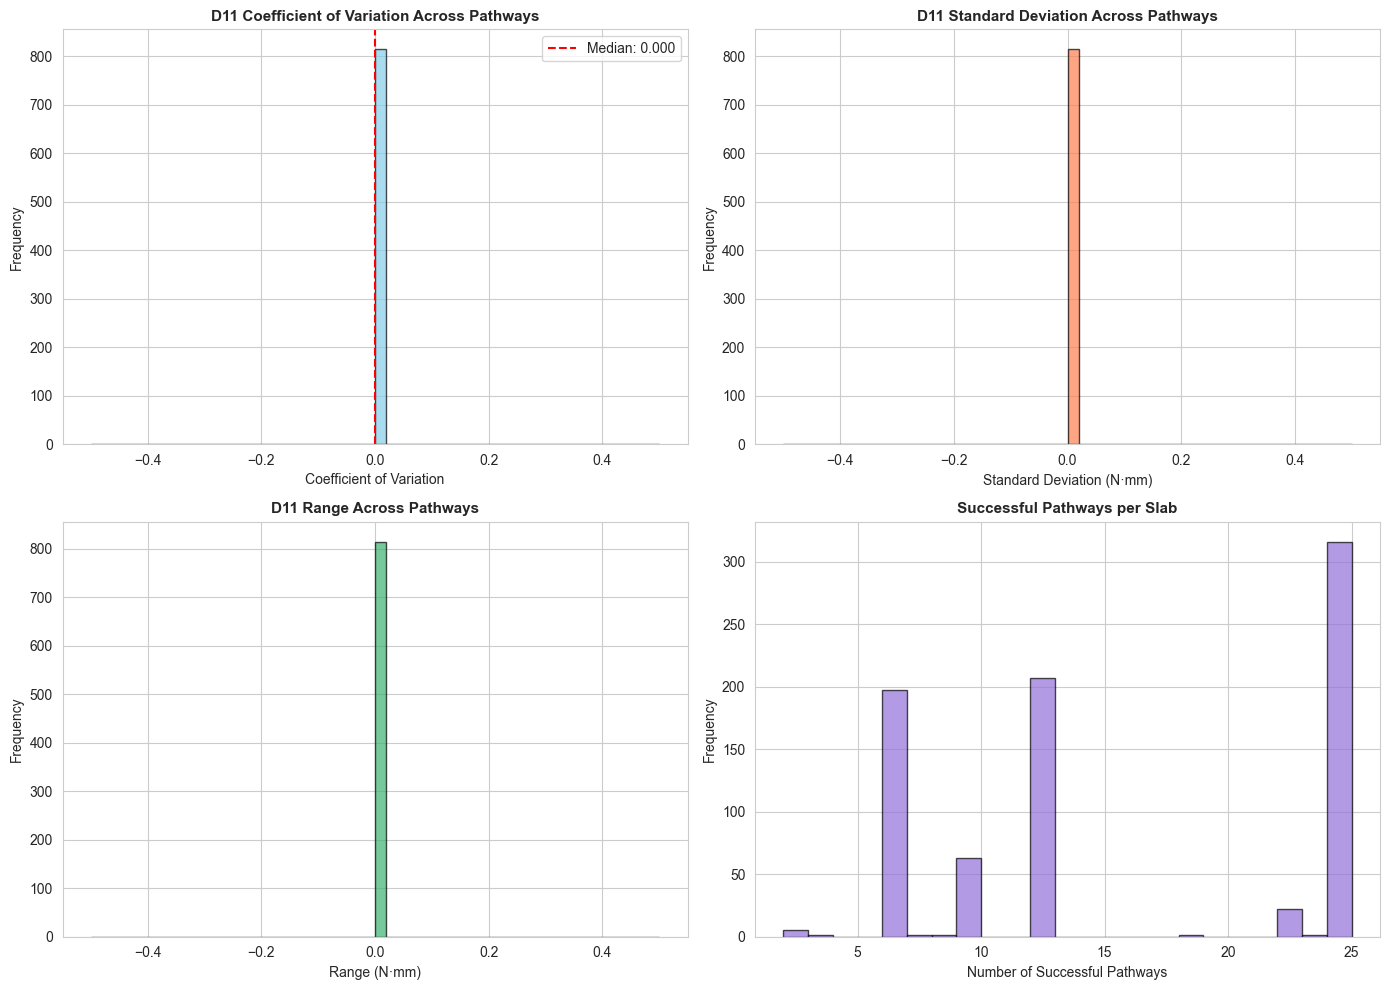

✓ Figure saved: D11_variability_distributions.png


In [16]:
# Visualize variability distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Coefficient of variation
axes[0, 0].hist(slab_variability['cv_D11'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Coefficient of Variation', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('D11 Coefficient of Variation Across Pathways', fontsize=11, fontweight='bold')
axes[0, 0].axvline(slab_variability['cv_D11'].median(), color='red', linestyle='--',
                   label=f'Median: {slab_variability["cv_D11"].median():.3f}')
axes[0, 0].legend()

# Standard deviation
axes[0, 1].hist(slab_variability['std_D11'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Standard Deviation (N·mm)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('D11 Standard Deviation Across Pathways', fontsize=11, fontweight='bold')

# Range
axes[1, 0].hist(slab_variability['range_D11'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 0].set_xlabel('Range (N·mm)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].set_title('D11 Range Across Pathways', fontsize=11, fontweight='bold')

# Successful pathways per slab
axes[1, 1].hist(slab_variability['n_pathways'],
                bins=range(int(slab_variability['n_pathways'].min()),
                          int(slab_variability['n_pathways'].max())+2),
                edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1, 1].set_xlabel('Number of Successful Pathways', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].set_title('Successful Pathways per Slab', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('D11_variability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: D11_variability_distributions.png")

## 8. Variability vs. Slab Properties

Investigate whether D11 variability correlates with slab characteristics.

In [17]:
# Merge slab properties with variability metrics
slab_properties = df_success.groupby('slab_id').agg({
    'num_layers': 'first',
    'slab_thickness_cm': 'first',
    'slope_angle_deg': 'first'
}).reset_index()

slab_variability_full = slab_variability.merge(slab_properties, on='slab_id')

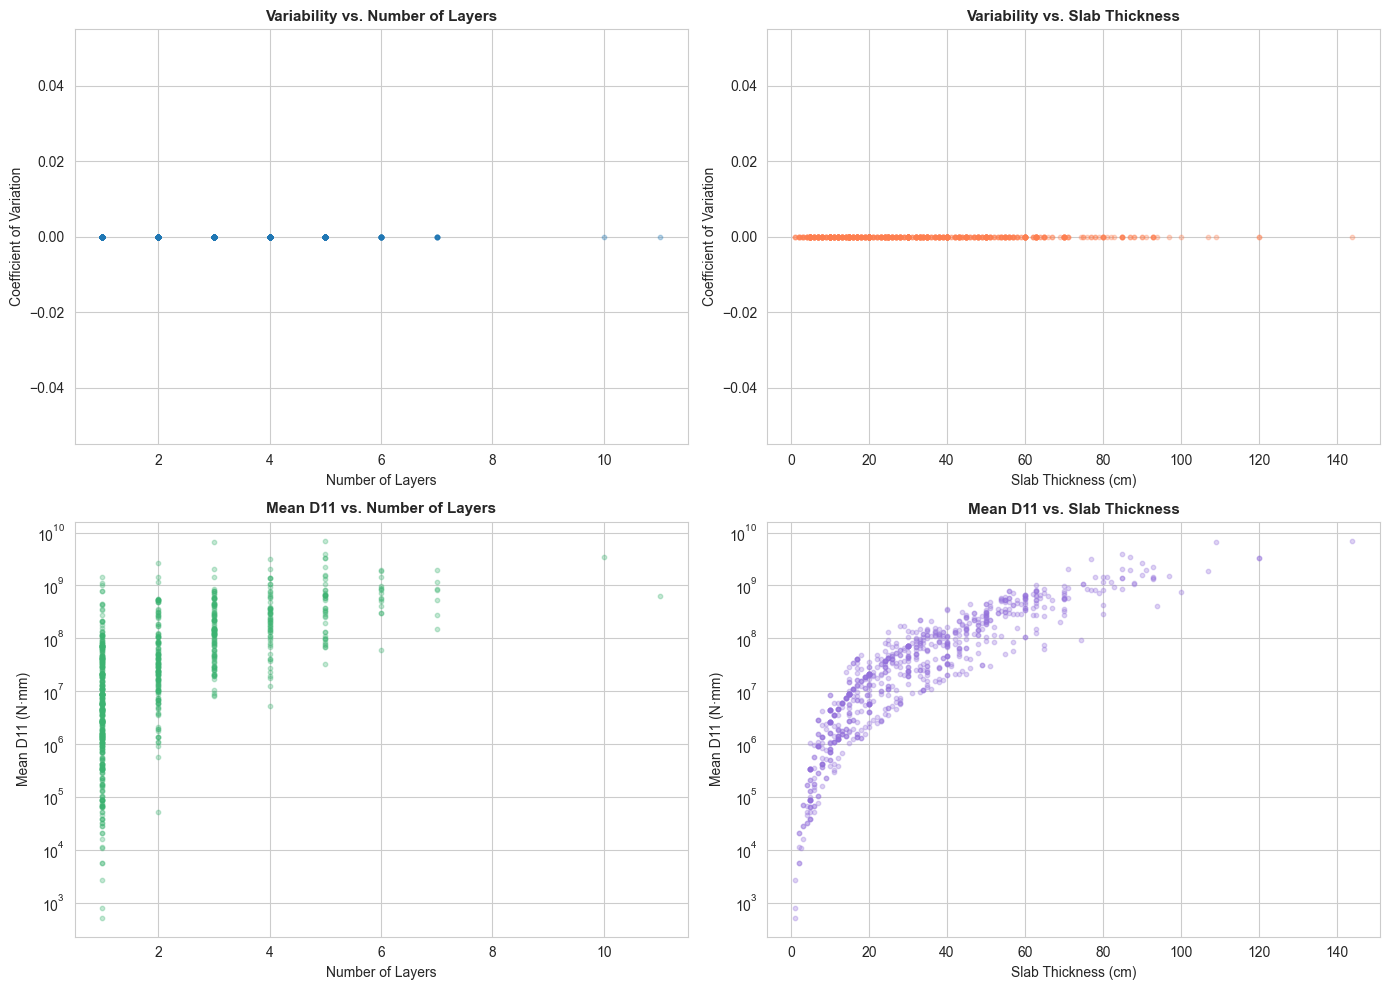

✓ Figure saved: variability_vs_properties.png


In [18]:
# Scatter plots: Variability vs properties
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CV vs number of layers
axes[0, 0].scatter(slab_variability_full['num_layers'], slab_variability_full['cv_D11'],
                   alpha=0.3, s=10)
axes[0, 0].set_xlabel('Number of Layers', fontsize=10)
axes[0, 0].set_ylabel('Coefficient of Variation', fontsize=10)
axes[0, 0].set_title('Variability vs. Number of Layers', fontsize=11, fontweight='bold')

# CV vs thickness
axes[0, 1].scatter(slab_variability_full['slab_thickness_cm'], slab_variability_full['cv_D11'],
                   alpha=0.3, s=10, color='coral')
axes[0, 1].set_xlabel('Slab Thickness (cm)', fontsize=10)
axes[0, 1].set_ylabel('Coefficient of Variation', fontsize=10)
axes[0, 1].set_title('Variability vs. Slab Thickness', fontsize=11, fontweight='bold')

# Mean D11 vs number of layers
axes[1, 0].scatter(slab_variability_full['num_layers'], slab_variability_full['mean_D11'],
                   alpha=0.3, s=10, color='mediumseagreen')
axes[1, 0].set_xlabel('Number of Layers', fontsize=10)
axes[1, 0].set_ylabel('Mean D11 (N·mm)', fontsize=10)
axes[1, 0].set_title('Mean D11 vs. Number of Layers', fontsize=11, fontweight='bold')
axes[1, 0].set_yscale('log')

# Mean D11 vs thickness
axes[1, 1].scatter(slab_variability_full['slab_thickness_cm'], slab_variability_full['mean_D11'],
                   alpha=0.3, s=10, color='mediumpurple')
axes[1, 1].set_xlabel('Slab Thickness (cm)', fontsize=10)
axes[1, 1].set_ylabel('Mean D11 (N·mm)', fontsize=10)
axes[1, 1].set_title('Mean D11 vs. Slab Thickness', fontsize=11, fontweight='bold')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig('variability_vs_properties.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: variability_vs_properties.png")

In [19]:
# Calculate correlation coefficients
print("\nCorrelation with coefficient of variation:")
print(f"  Num layers: {slab_variability_full['num_layers'].corr(slab_variability_full['cv_D11']):.3f}")
print(f"  Thickness: {slab_variability_full['slab_thickness_cm'].corr(slab_variability_full['cv_D11']):.3f}")
print(f"  Slope angle: {slab_variability_full['slope_angle_deg'].corr(slab_variability_full['cv_D11']):.3f}")

print("\nCorrelation with mean D11:")
print(f"  Num layers: {slab_variability_full['num_layers'].corr(slab_variability_full['mean_D11']):.3f}")
print(f"  Thickness: {slab_variability_full['slab_thickness_cm'].corr(slab_variability_full['mean_D11']):.3f}")
print(f"  Slope angle: {slab_variability_full['slope_angle_deg'].corr(slab_variability_full['mean_D11']):.3f}")


Correlation with coefficient of variation:
  Num layers: nan
  Thickness: nan
  Slope angle: nan

Correlation with mean D11:
  Num layers: 0.454
  Thickness: 0.687
  Slope angle: -0.041


## 9. Summary Statistics

In [20]:
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDataset:")
print(f"  Total ECTP slabs: {len(all_slabs):,}")
print(f"  Total pathway executions: {len(df_results):,}")
print(f"  Overall success rate: {100 * df_results['success'].mean():.1f}%")

print(f"\nD11 Results:")
print(f"  Successful D11 calculations: {len(df_success):,}")
print(f"  Unique slabs with D11: {df_success['slab_id'].nunique():,}")
print(f"  Mean D11: {df_success['D11'].mean():.2f} N·mm")
print(f"  Median D11: {df_success['D11'].median():.2f} N·mm")
print(f"  Std dev D11: {df_success['D11'].std():.2f} N·mm")

print(f"\nInter-Pathway Variability:")
print(f"  Mean CV: {slab_variability['cv_D11'].mean():.4f} ({100*slab_variability['cv_D11'].mean():.2f}%)")
print(f"  Median CV: {slab_variability['cv_D11'].median():.4f} ({100*slab_variability['cv_D11'].median():.2f}%)")
print(f"  Mean pathways per slab: {slab_variability['n_pathways'].mean():.1f}")

print(f"\nMost successful methods:")
print(f"  Density: {density_success.index[0]} ({density_success.iloc[0]['success_rate_%']:.1f}%)")
print(f"  Elastic modulus: {E_success.index[0]} ({E_success.iloc[0]['success_rate_%']:.1f}%)")
print(f"  Poisson's ratio: {nu_success.index[0]} ({nu_success.iloc[0]['success_rate_%']:.1f}%)")

print("\n" + "="*80)
print("Analysis complete!")
print("="*80)

SUMMARY STATISTICS

Dataset:
  Total ECTP slabs: 14,776
  Total pathway executions: 472,832
  Overall success rate: 2.6%

D11 Results:
  Successful D11 calculations: 12,370
  Unique slabs with D11: 815
  Mean D11: 133369961.70 N·mm
  Median D11: 20088183.34 N·mm
  Std dev D11: 420625020.30 N·mm

Inter-Pathway Variability:
  Mean CV: 0.0000 (0.00%)
  Median CV: 0.0000 (0.00%)
  Mean pathways per slab: 15.2

Most successful methods:
  Density: kim_jamieson_table5 (3.5%)
  Elastic modulus: schottner (3.0%)
  Poisson's ratio: kochle (3.1%)

Analysis complete!
